In [2]:
# IMPORTS
import numpy as np
import pandas as pd
import requests


#Fin Data Sources
import yfinance as yf
import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.express as px

import time
from datetime import date

# for graphs
import matplotlib.pyplot as plt

In [3]:

import requests
from io import StringIO

def get_url_info(url) -> pd.DataFrame:
    """
    Fetch IPO data for the given year from stockanalysis.com.
    """
    # url = f"https://stockanalysis.com/ipos/withdrawn/"
    headers = {
        'User-Agent': (
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
            'AppleWebKit/537.36 (KHTML, like Gecko) '
            'Chrome/58.0.3029.110 Safari/537.3'
        )
    }

    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()

        # Wrap HTML text in StringIO to avoid deprecation warning
        # "Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object."
        html_io = StringIO(response.text)
        tables = pd.read_html(html_io)

        if not tables:
            raise ValueError(f"No tables found for withdrawn ipos.")

        return tables[0]

    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
    except ValueError as ve:
        print(f"Data error: {ve}")
    except Exception as ex:
        print(f"Unexpected error: {ex}")

    return pd.DataFrame()

In [4]:
withdrawn_ipos = get_url_info(url="https://stockanalysis.com/ipos/withdrawn/")
withdrawn_ipos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Symbol          100 non-null    object
 1   Company Name    100 non-null    object
 2   Price Range     100 non-null    object
 3   Shares Offered  100 non-null    object
dtypes: object(4)
memory usage: 3.3+ KB


In [5]:
def get_company_class(company_name):
    if pd.isna(company_name):
        return 'Other'
    
    company_name = company_name.lower()
    
    if 'acquisition corp' in company_name or 'acquisition corporation' in company_name:
        return 'Acq.Corp'
    elif 'inc' in company_name or 'incorporated' in company_name:
        return 'Inc'
    elif 'group' in company_name:
        return 'Group'
    elif 'holdings' in company_name:
        return 'Holdings'
    elif 'ltd' in company_name or 'limited' in company_name:
        return 'Ltd'
    else:
        return 'Other'

withdrawn_ipos['Company Class'] = withdrawn_ipos['Company Name'].apply(get_company_class)

In [6]:
def get_avg_price(price_range) -> float:
    if pd.isna(price_range) or price_range == '-':
        return None
    
    # Remove '$' and split on '-' to get range bounds
    price_range = price_range.replace('$', '')
    prices = price_range.split('-')
    
    # Convert prices to float
    prices = [float(p) for p in prices]
    
    # If single price, return it
    if len(prices) == 1:
        return prices[0]
    
    # Otherwise return average of range
    return sum(prices) / len(prices)

withdrawn_ipos['Avg. Price'] = withdrawn_ipos['Price Range'].apply(get_avg_price)

withdrawn_ipos.describe(include='all')


,Symbol,Company Name,Price Range,Shares Offered,Company Class,Avg. Price
count,100,100,100,100,100,73.000000
unique,100,100,30,48,6,NaN
top,ODTX,"Odyssey Therapeutics, Inc.",-,-,Inc,NaN
freq,1,1,27,28,51,NaN
mean,NaN,NaN,NaN,NaN,NaN,7.918493
std,NaN,NaN,NaN,NaN,NaN,3.882649
min,NaN,NaN,NaN,NaN,NaN,2.250000
25%,NaN,NaN,NaN,NaN,NaN,5.000000
50%,NaN,NaN,NaN,NaN,NaN,6.500000
75%,NaN,NaN,NaN,NaN,NaN,10.000000


In [7]:
withdrawn_ipos

,Symbol,Company Name,Price Range,Shares Offered,Company Class,Avg. Price
0,ODTX,"Odyssey Therapeutics, Inc.",-,-,Inc,NaN
1,UNFL,"Unifoil Holdings, Inc.",$3.00 - $4.00,2000000,Inc,3.5
2,AURN,"Aurion Biotech, Inc.",-,-,Inc,NaN
3,ROTR,"PHI Group, Inc.",-,-,Inc,NaN
4,ONE,One Power Company,-,-,Other,NaN
...,...,...,...,...,...,...
95,FHP,"Freehold Properties, Inc.",-,-,Inc,NaN
96,CHO,Chobani Inc.,-,-,Inc,NaN
97,IFIT,iFIT Health & Fitness Inc.,$18.00 - $21.00,30769231,Inc,19.5
98,GLGX,"Gerson Lehrman Group, Inc.",-,-,Inc,NaN


In [8]:
# Q1 which company class has the highest withdrawn value?
if withdrawn_ipos['Shares Offered'].dtype == 'object':
    withdrawn_ipos['Shares Offered'] = withdrawn_ipos['Shares Offered'].str.replace('-', 'NaN').astype(float)
    
    
sum(~withdrawn_ipos['Shares Offered'].isna())


withdrawn_ipos['Withdrawn Value'] = withdrawn_ipos['Avg. Price'] * withdrawn_ipos['Shares Offered']
sum(~withdrawn_ipos['Withdrawn Value'].isna())

total_withdrawn_value_by_class = withdrawn_ipos.groupby("Company Class")["Withdrawn Value"].sum().sort_values(ascending=False)

print(total_withdrawn_value_by_class)
print(f"highest withdrawn value: {total_withdrawn_value_by_class.index[0]}    {total_withdrawn_value_by_class[0]:.2e}")



Company Class
Acq.Corp    4.021000e+09
Inc         2.257164e+09
Other       7.679200e+08
Ltd         3.217346e+08
Holdings    3.030000e+08
Group       3.378750e+07
Name: Withdrawn Value, dtype: float64
highest withdrawn value: Acq.Corp    4.02e+09


In [9]:
ipos_2024=get_url_info(url="https://stockanalysis.com/ipos/2024/")

In [12]:
if ipos_2024['IPO Date'].dtype == 'object':
    ipos_2024['IPO Date'] = pd.to_datetime(ipos_2024['IPO Date'])

ipos_2024_first5months=ipos_2024[ipos_2024['IPO Date'].dt.month <= 5]

print(len(ipos_2024_first5months))


77


In [13]:
ipos_2024_first5months.head()

,IPO Date,Symbol,Company Name,IPO Price,Current,Return
148,2024-05-31,NAKA,"Kindly MD, Inc.",-,$11.60,-
149,2024-05-23,BOW,Bowhead Specialty Holdings Inc.,$17.00,$34.92,103.21%
150,2024-05-17,HDL,Super Hi International Holding Ltd.,$19.56,$21.00,7.36%
151,2024-05-17,RFAI,RF Acquisition Corp II,$10.00,$10.52,5.00%
152,2024-05-15,JDZG,JIADE Limited,$4.00,$0.32,-93.04%


In [14]:
import time

stocks_df = pd.DataFrame({'A' : []})

for i,ticker in enumerate(ipos_2024_first5months['Symbol']):
  print(i,ticker)

  # Work with stock prices
  ticker_obj = yf.Ticker(ticker)

  # historyPrices = yf.download(tickers = ticker,
  #                    period = "max",
  #                    interval = "1d")
  historyPrices = ticker_obj.history(
                     period = "max",
                     interval = "1d")

  # generate features for historical prices, and what we want to predict
  historyPrices['Ticker'] = ticker
  historyPrices['Year']= historyPrices.index.year
  historyPrices['Month'] = historyPrices.index.month
  historyPrices['Weekday'] = historyPrices.index.weekday
  historyPrices['Date'] = historyPrices.index.date

  # historical returns
  for i in [1,3,7,30,90,365]:
    historyPrices['growth_'+str(i)+'d'] = historyPrices['Close'] / historyPrices['Close'].shift(i)
  historyPrices['growth_future_30d'] = historyPrices['Close'].shift(-5) / historyPrices['Close']

  # Technical indicators
  # SimpleMovingAverage 10 days and 20 days
  historyPrices['SMA10']= historyPrices['Close'].rolling(10).mean()
  historyPrices['SMA20']= historyPrices['Close'].rolling(20).mean()
  historyPrices['growing_moving_average'] = np.where(historyPrices['SMA10'] > historyPrices['SMA20'], 1, 0)
  historyPrices['high_minus_low_relative'] = (historyPrices.High - historyPrices.Low) / historyPrices['Close']

  # 30d rolling volatility : https://ycharts.com/glossary/terms/rolling_vol_30
  historyPrices['volatility'] =   historyPrices['Close'].rolling(30).std() * np.sqrt(252)

  # what we want to predict
  historyPrices['is_positive_growth_30d_future'] = np.where(historyPrices['growth_future_30d'] > 1, 1, 0)

  # sleep 1 sec between downloads - not to overload the API server
  time.sleep(1)


  if stocks_df.empty:
    stocks_df = historyPrices
  else:
    stocks_df = pd.concat([stocks_df, historyPrices], ignore_index=True)
     

0 NAKA
1 BOW
2 HDL
3 RFAI
4 JDZG
5 RAY
6 BTOC
7 ZK
8 GPAT
9 PAL
10 SVCO
11 NNE
12 CCIX
13 VIK
14 ZONE
15 LOAR
16 MRX
17 RBRK
18 NCI
19 MFI
20 YYGH
21 TRSG
22 CDTG
23 CTRI
24 IBTA
25 MTEN
26 SUPX
27 TWG
28 ULS
29 PACS
30 MNDR
31 CTNM
32 MAMO
33 ZBAO
34 BOLD
35 MMA
36 UBXG
37 IBAC
38 AUNA
39 BKHA
40 LOBO
41 RDDT
42 ALAB
43 INTJ
44 RYDE
45 LGCL
46 SMXT
47 VHAI
48 DYCQ
49 CHRO
50 UMAC
51 HLXB
52 MGX
53 TBBB
54 TELO
55 KYTX
56 PMNT
57 AHR
58 LEGT
59 ANRO
60 GUTS
61 AS
62 FBLG
63 AVBP
64 BTSG
65 HAO
66 CGON
67 YIBO
68 JL
69 SUGP
70 JVSA
71 KSPI
72 CCTG
73 PSBD
74 SYNX
75 SDHC
76 ROMA


In [15]:
# Add 252d growth column using pandas shift
stocks_df['growth_252d'] = stocks_df.groupby('Ticker')['Close'].transform(lambda x: x / x.shift(252))


In [16]:

stocks_df['Sharpe'] = (stocks_df['growth_252d'] - 0.045) / stocks_df['volatility']

In [17]:
stocks_df['Date'].head()


0    2024-05-31
1    2024-06-03
2    2024-06-04
3    2024-06-05
4    2024-06-06
Name: Date, dtype: object

In [18]:
# Q2 what is the median sharpe ratio for the month of June 2025 for companies that went public in the first 5 months of 2024?
date_str = "2025-06-06"
stocks_df[stocks_df['Date'].astype('str')== date_str][['Sharpe','growth_252d']].agg(['count', 'mean', 'std', 'min', lambda x: x.quantile(0.25), 'median', lambda x: x.quantile(0.75), 'max']).round(6)

,Sharpe,growth_252d
count,73.000000,73.000000
mean,0.297523,1.227948
std,0.523190,1.480237
min,-0.079677,0.024970
<lambda>,0.040265,0.293510
median,0.083768,0.763188
<lambda>,0.331967,1.446667
max,2.835668,8.097413


In [19]:
AA=stocks_df[stocks_df['Date'].astype('str')== date_str].sort_values(by='Sharpe', ascending=False)
BB=stocks_df[stocks_df['Date'].astype('str')== date_str].sort_values(by='growth_252d', ascending=False)


CC=pd.concat([
    AA[['Ticker', 'Sharpe', 'growth_252d']].rename(columns={'Sharpe': 'Sharpe_AA', 'growth_252d': 'growth_252d_AA'}),
    BB[['Ticker', 'Sharpe', 'growth_252d']].rename(columns={'Sharpe': 'Sharpe_BB', 'growth_252d': 'growth_252d_BB'})
], axis=1).drop_duplicates()

CC.head(10)

,Ticker,Sharpe_AA,growth_252d_AA,Ticker,Sharpe_BB,growth_252d_BB
11178,BKHA,2.835668,1.045881,BKHA,2.835668,1.045881
21224,JVSA,2.041531,1.071076,JVSA,2.041531,1.071076
17139,LEGT,1.940267,1.049407,LEGT,1.940267,1.049407
10603,IBAC,1.637119,1.044611,IBAC,1.637119,1.044611
5077,NCI,1.181375,0.572687,NCI,1.181375,0.572687
14831,HLXB,1.123493,1.061404,HLXB,1.123493,1.061404
8529,MNDR,0.974234,1.030769,MNDR,0.974234,1.030769
13838,DYCQ,0.969321,1.059863,DYCQ,0.969321,1.059863
12402,INTJ,0.744512,0.661386,INTJ,0.744512,0.661386
20564,JL,0.566222,8.097413,JL,0.566222,8.097413


In [21]:
num_months=range(1,12,1)
for i in num_months:
    stocks_df[f'future_growth_{i}m']=stocks_df['Close'].shift(-i)/stocks_df['Close']
len(stocks_df['Ticker'].unique()) 

77

In [22]:
min_date = stocks_df.groupby('Ticker').agg({'Date': 'first',}).reset_index()

# Display all rows instead of just first 5
min_date_joined_stocks_df=min_date.merge(stocks_df, on=['Ticker', 'Date'], how='inner')


In [23]:

# Get all columns that start with 'future'
future_columns = [col for col in min_date_joined_stocks_df.columns if col.startswith('future')]
min_date_joined_stocks_df_stats=min_date_joined_stocks_df[['Date','Ticker']+future_columns].describe()



In [96]:
# Q3 What is the optimal number of months (1 to 12) to hold a newly IPO'd stock in order to maximize average growth? the sortedfuture growth sorted by the mean
min_date_joined_stocks_df_stats.loc['mean',future_columns].sort_values(ascending=False)


future_growth_3m     1.078582
future_growth_2m     1.063696
future_growth_4m     1.047177
future_growth_6m     1.043419
future_growth_7m     1.039056
future_growth_5m     1.038392
future_growth_9m     1.036341
future_growth_8m     1.031936
future_growth_11m    1.014684
future_growth_10m    1.010579
future_growth_1m     1.007921
Name: mean, dtype: float64

In [25]:
import gdown
import os
if not os.path.exists("data.parquet"):
    file_id = "1grCTCzMZKY5sJRtdbLVCXg8JXA8VPyg-"
    gdown.download(f"https://drive.google.com/uc?id={file_id}", "data.parquet", quiet=False)
df = pd.read_parquet("data.parquet", engine="pyarrow")


In [26]:
rsi_threshold = 25
selected_df = df[
    (df['rsi'] < rsi_threshold) &
    (df['Date'] >= '2000-01-01') &
    (df['Date'] <= '2025-06-01')
]


In [28]:
# Q4  What is the total profit (in $thousands) you would have earned by investing $1000 every time a stock was oversold (RSI < 25)?
net_income = 1000 * (selected_df['growth_future_30d'] - 1).mean()
print(f"Net income: {net_income:.2f}")


Net income: 24295.52


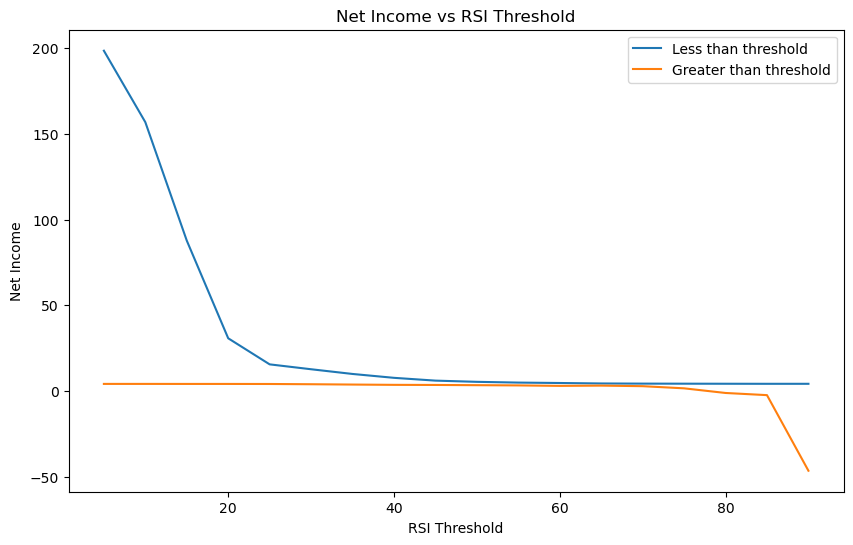

Net incomes for RSI less than threshold:
RSI 5: 198.57
RSI 10: 156.86
RSI 15: 87.74
RSI 20: 30.71
RSI 25: 15.49
RSI 30: 12.64
RSI 35: 9.89
RSI 40: 7.63
RSI 45: 6.00
RSI 50: 5.30
RSI 55: 4.85
RSI 60: 4.62
RSI 65: 4.34
RSI 70: 4.25
RSI 75: 4.21
RSI 80: 4.18
RSI 85: 4.14
RSI 90: 4.15

Net incomes for RSI greater than threshold:
RSI 5: 4.09
RSI 10: 4.09
RSI 15: 4.07
RSI 20: 4.07
RSI 25: 4.04
RSI 30: 3.89
RSI 35: 3.70
RSI 40: 3.53
RSI 45: 3.47
RSI 50: 3.34
RSI 55: 3.21
RSI 60: 2.94
RSI 65: 3.09
RSI 70: 2.76
RSI 75: 1.50
RSI 80: -1.21
RSI 85: -2.47
RSI 90: -46.59


In [48]:
rsi_thresholds = range(5, 95, 5)
net_incomes_less_than_threshold = np.nan * np.ones(len(rsi_thresholds))
net_incomes_greater_than_threshold = np.nan * np.ones(len(rsi_thresholds))
for i, rsi_threshold in enumerate(rsi_thresholds):
    selected_df_less_than_threshold = df[
        (df['rsi'] < rsi_threshold) &
        (df['Date'] >= '2000-01-01') &
        (df['Date'] <= '2025-06-01')
    ]
    selected_df_greater_than_threshold = df[
        (df['rsi'] > rsi_threshold) &
        (df['Date'] >= '2000-01-01') &
        (df['Date'] <= '2025-06-01')
    ]
    net_incomes_less_than_threshold[i] = 1000 * (selected_df_less_than_threshold['growth_future_30d'] - 1).mean()
    net_incomes_greater_than_threshold[i] = 1000 * (selected_df_greater_than_threshold['growth_future_30d'] - 1).mean()

plt.figure(figsize=(10, 6))
plt.plot(rsi_thresholds, net_incomes_less_than_threshold, label='Less than threshold')
plt.plot(rsi_thresholds, net_incomes_greater_than_threshold, label='Greater than threshold')
plt.xlabel('RSI Threshold')
plt.ylabel('Net Income')
plt.title('Net Income vs RSI Threshold')
plt.legend()
plt.show()
print("Net incomes for RSI less than threshold:")
for threshold, income in zip(rsi_thresholds, net_incomes_less_than_threshold):
    print(f"RSI {threshold}: {income:.2f}")

print("\nNet incomes for RSI greater than threshold:")
for threshold, income in zip(rsi_thresholds, net_incomes_greater_than_threshold):
    print(f"RSI {threshold}: {income:.2f}")


In [54]:
list(df.columns)

['Open',
 'High',
 'Low',
 'Close_x',
 'Volume',
 'Dividends',
 'Stock Splits',
 'Ticker',
 'Year',
 'Month',
 'Weekday',
 'Date',
 'growth_1d',
 'growth_3d',
 'growth_7d',
 'growth_30d',
 'growth_90d',
 'growth_365d',
 'growth_future_30d',
 'SMA10',
 'SMA20',
 'growing_moving_average',
 'high_minus_low_relative',
 'volatility',
 'is_positive_growth_30d_future',
 'ticker_type',
 'index_x',
 'adx',
 'adxr',
 'apo',
 'aroon_1',
 'aroon_2',
 'aroonosc',
 'bop',
 'cci',
 'cmo',
 'dx',
 'macd',
 'macdsignal',
 'macdhist',
 'macd_ext',
 'macdsignal_ext',
 'macdhist_ext',
 'macd_fix',
 'macdsignal_fix',
 'macdhist_fix',
 'mfi',
 'minus_di',
 'mom',
 'plus_di',
 'dm',
 'ppo',
 'roc',
 'rocp',
 'rocr',
 'rocr100',
 'rsi',
 'slowk',
 'slowd',
 'fastk',
 'fastd',
 'fastk_rsi',
 'fastd_rsi',
 'trix',
 'ultosc',
 'willr',
 'index_y',
 'ad',
 'adosc',
 'obv',
 'atr',
 'natr',
 'ht_dcperiod',
 'ht_dcphase',
 'ht_phasor_inphase',
 'ht_phasor_quadrature',
 'ht_sine_sine',
 'ht_sine_leadsine',
 'ht_tren

In [83]:
print(list(df['Ticker'].unique()))

['MSFT', 'AAPL', 'GOOG', 'NVDA', 'AMZN', 'META', 'BRK-B', 'LLY', 'AVGO', 'V', 'JPM', 'NVO', 'MC.PA', 'ASML', 'RMS.PA', 'OR.PA', 'SAP', 'ACN', 'TTE', 'SIE.DE', 'IDEXY', 'CDI.PA', 'RELIANCE.NS', 'TCS.NS', 'HDB', 'BHARTIARTL.NS', 'IBN', 'SBIN.NS', 'LICI.NS', 'INFY', 'ITC.NS', 'HINDUNILVR.NS', 'LT.NS']


Net incomes for RSI less than threshold:
    future_growth_21d  future_growth_42d  future_growth_63d  \
5           29.021230          27.991934          20.872585   
10          24.805536          23.655107          17.882696   
15          13.151863          11.241205           8.124446   
20           6.278840           4.466039           3.488448   
25           2.991704           1.999883           1.446565   
30           1.955029           1.245639           0.997807   
35           1.444226           1.048227           0.811066   
40           1.170605           0.926655           0.744126   
45           0.970447           0.813932           0.694632   
50           0.857412           0.742906           0.664016   
55           0.787406           0.698103           0.649974   
60           0.698103           0.649327           0.627499   
65           0.653275           0.630326           0.624551   
70           0.650362           0.631139           0.629892   
75           0

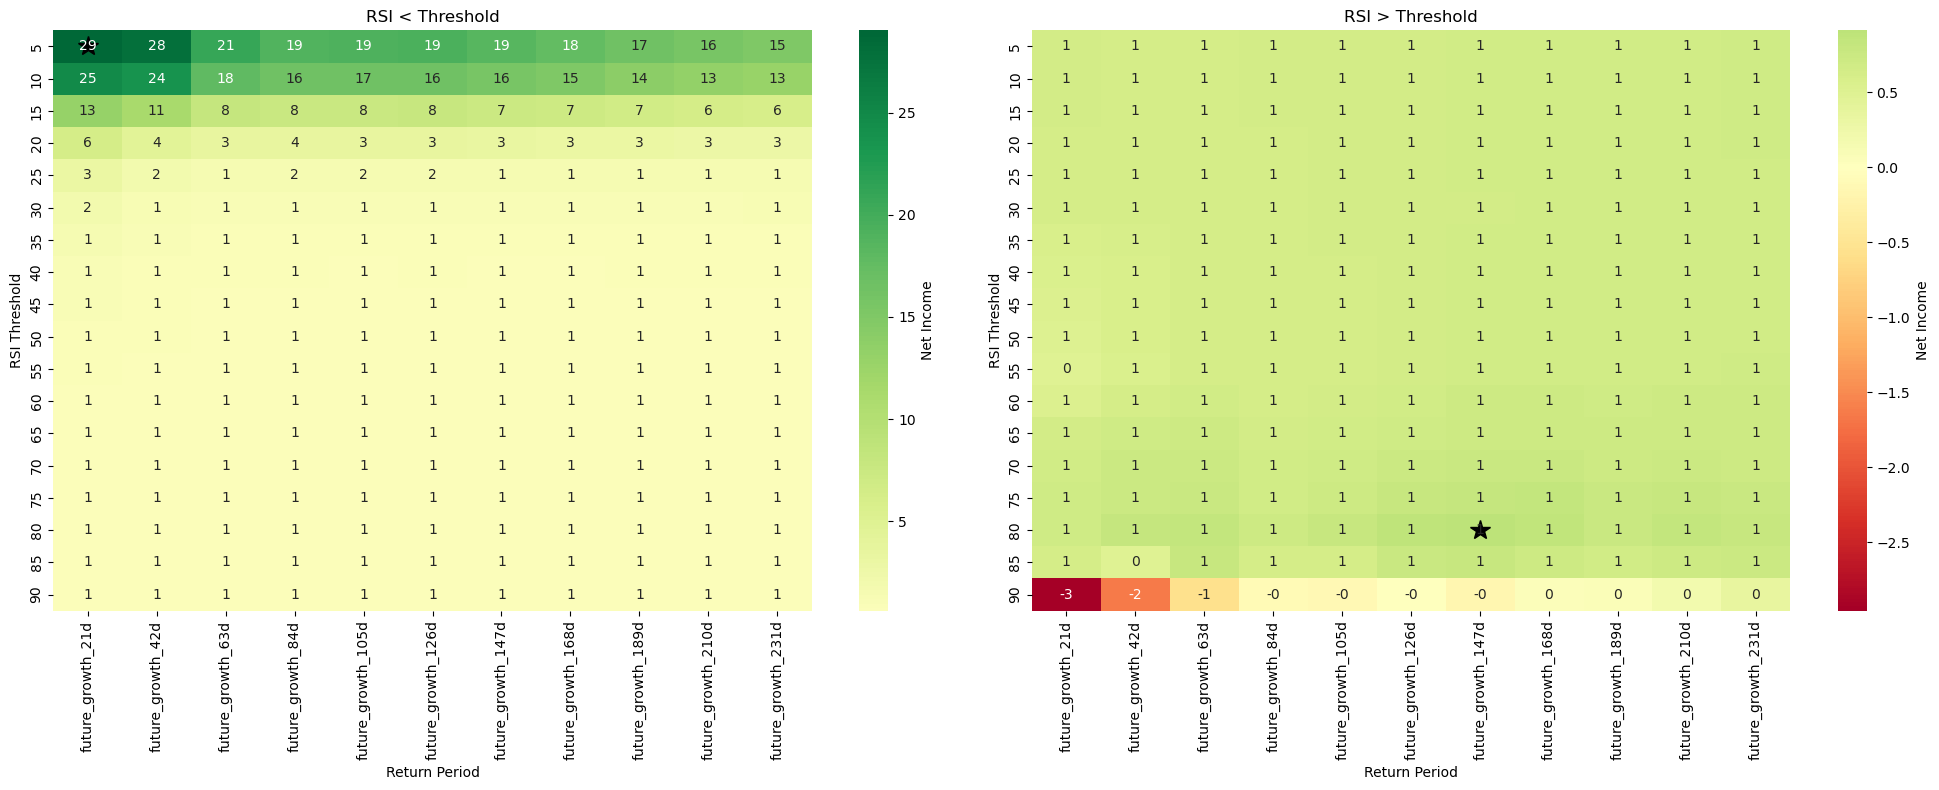

In [58]:
import seaborn as sns
rsi_thresholds = range(5, 95, 5)
future_days = range(21, 12*21, 21)

for future_day in future_days:
    df[f'future_growth_{future_day}d'] = df['Close_x'].shift(-future_day) / df['Close_x']

growth_columns = [col for col in df.columns if col.startswith('future_growth_')]
net_incomes_less_than_threshold = np.full((len(rsi_thresholds), len(growth_columns)), np.nan)
net_incomes_greater_than_threshold = np.full((len(rsi_thresholds), len(growth_columns)), np.nan)
for i, rsi_threshold in enumerate(rsi_thresholds):
    selected_df_less_than_threshold = df[
        (df['rsi'] < rsi_threshold) &
        (df['Date'] >= '2000-01-01') &
        (df['Date'] <= '2025-06-01')
    ]
    selected_df_greater_than_threshold = df[
        (df['rsi'] > rsi_threshold) &
        (df['Date'] >= '2000-01-01') &
        (df['Date'] <= '2025-06-01')
    ]
    net_incomes_less_than_threshold[i,:] = 1000 * (selected_df_less_than_threshold[growth_columns] - 1).mean()
    net_incomes_greater_than_threshold[i,:] = 1000 * (selected_df_greater_than_threshold[growth_columns] - 1).mean()

net_incomes_less_than_threshold = net_incomes_less_than_threshold / np.array(future_days)[None,:]
net_incomes_greater_than_threshold = net_incomes_greater_than_threshold / np.array(future_days)[None,:]


net_incomes_less_than_threshold_df = pd.DataFrame(net_incomes_less_than_threshold, index=rsi_thresholds, columns=growth_columns)
net_incomes_greater_than_threshold_df = pd.DataFrame(net_incomes_greater_than_threshold, index=rsi_thresholds, columns=growth_columns)
print("Net incomes for RSI less than threshold:")
print(net_incomes_less_than_threshold_df)

print("\nNet incomes for RSI greater than threshold:")
print(net_incomes_greater_than_threshold_df)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot for less than threshold
sns.heatmap(net_incomes_less_than_threshold_df, 
            cmap='RdYlGn',
            center=0,
            annot=True,
            fmt='.0f',
            cbar_kws={'label': 'Net Income'},
            ax=ax1)
ax1.set_title('RSI < Threshold')
ax1.set_xlabel('Return Period')
ax1.set_ylabel('RSI Threshold')

# Plot for greater than threshold
sns.heatmap(net_incomes_greater_than_threshold_df, 
            cmap='RdYlGn',
            center=0,
            annot=True,
            fmt='.0f',
            cbar_kws={'label': 'Net Income'},
            ax=ax2)
ax2.set_title('RSI > Threshold')
ax2.set_xlabel('Return Period')
ax2.set_ylabel('RSI Threshold')

# Mark maximum values
max_idx_less = np.unravel_index(net_incomes_less_than_threshold_df.values.argmax(), 
                               net_incomes_less_than_threshold_df.shape)
max_idx_greater = np.unravel_index(net_incomes_greater_than_threshold_df.values.argmax(), 
                                  net_incomes_greater_than_threshold_df.shape)

ax1.plot(max_idx_less[1] + 0.5, max_idx_less[0] + 0.5, 'k*', markersize=15)
ax2.plot(max_idx_greater[1] + 0.5, max_idx_greater[0] + 0.5, 'k*', markersize=15)

plt.tight_layout()
plt.show()



In [75]:
list(future_days)

[21, 42, 63, 84, 105, 126, 147, 168, 189, 210, 231]

['MSFT', 'AAPL', 'NVDA', 'AMZN', 'META', 'BRK-B', 'LLY', 'JPM', 'NVO', 'MC.PA', 'ASML', 'RMS.PA', 'OR.PA', 'SAP', 'ACN', 'TTE', 'SIE.DE', 'IDEXY', 'CDI.PA', 'RELIANCE.NS', 'TCS.NS', 'HDB', 'BHARTIARTL.NS', 'IBN', 'SBIN.NS', 'LICI.NS', 'INFY', 'ITC.NS', 'HINDUNILVR.NS', 'LT.NS']
    MSFT  AAPL  GOOG  NVDA  AMZN  META  BRK-B  LLY  AVGO    V   JPM  NVO  \
5    0.0   0.0   0.0   0.0   0.0   0.0    0.0  0.0   0.0  0.0   0.0  0.0   
10   0.0   0.0   0.0   0.0   0.0   0.0    0.0  0.0   0.0  0.0   0.0  0.0   
15   0.0   0.0   0.0   8.0   0.0   0.0    0.0  2.0   0.0  0.0   2.0  0.0   
20   4.0   1.0   0.0  21.0   3.0   2.0    3.0  8.0   0.0  0.0  14.0  6.0   

    MC.PA  ASML  RMS.PA  OR.PA   SAP  ACN   TTE  SIE.DE  IDEXY  CDI.PA  \
5     0.0   0.0     0.0    0.0   0.0  0.0   0.0     0.0    0.0     0.0   
10    1.0   0.0     0.0    0.0   0.0  0.0   0.0     8.0    0.0     0.0   
15    9.0   1.0     1.0    0.0   6.0  0.0   0.0    12.0    1.0     9.0   
20   20.0   4.0    32.0    2.0  12.0  2.0  1

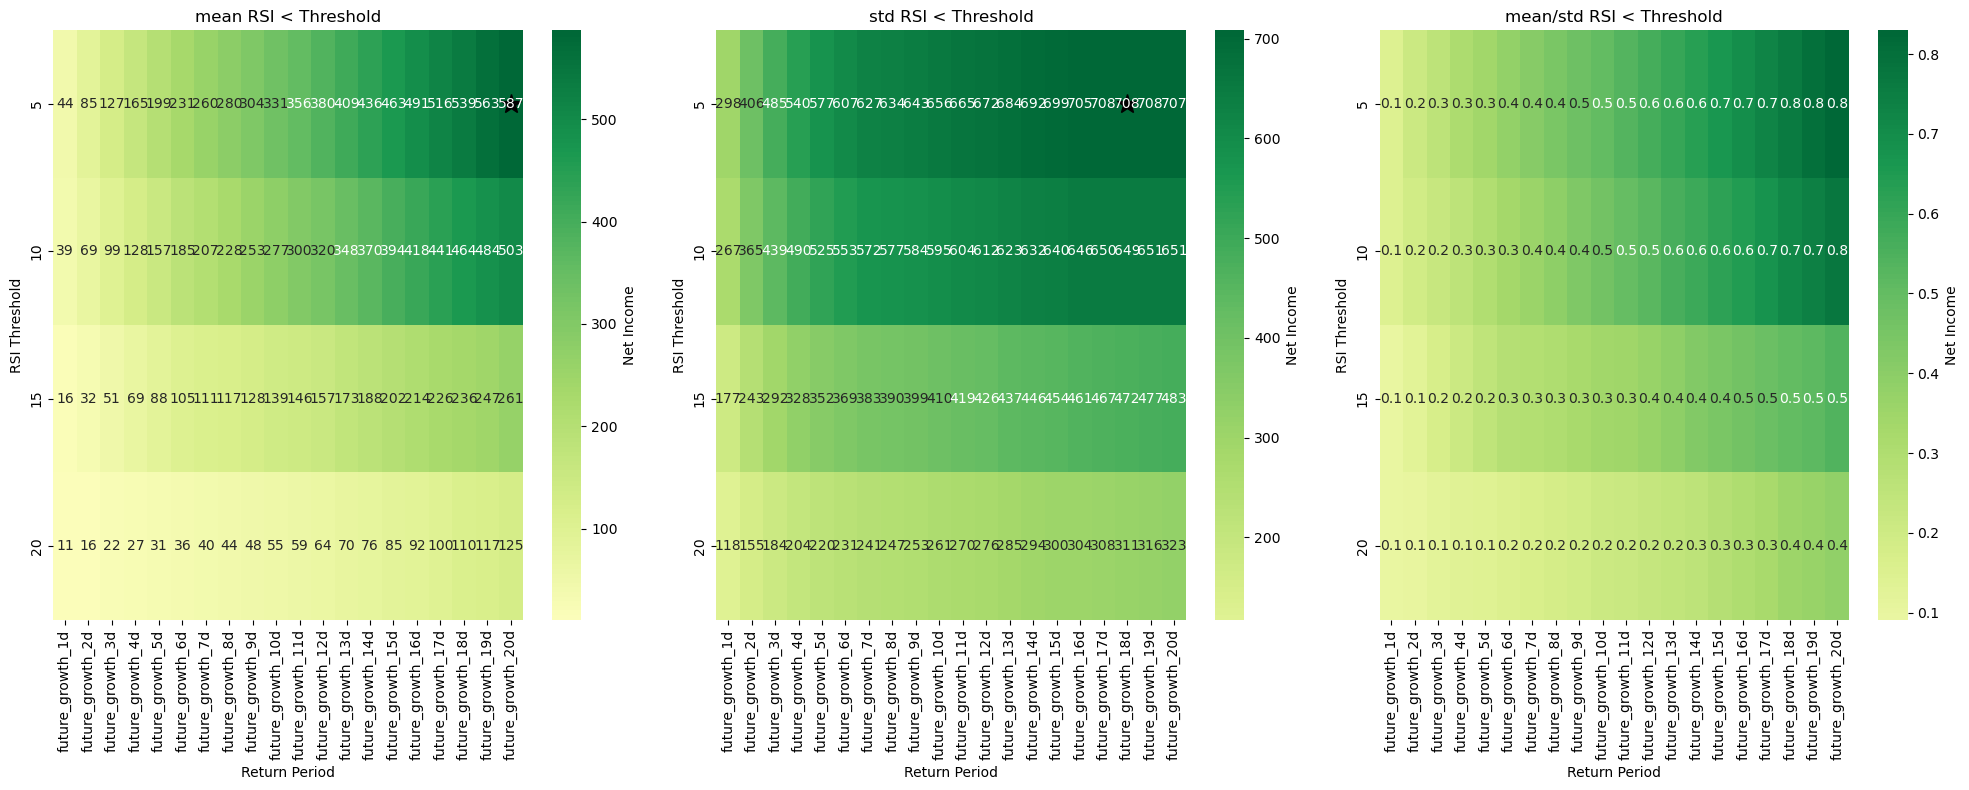

In [91]:
import seaborn as sns
rsi_thresholds = range(5, 25, 5)
# future_days = range(1,21, 1)

# for future_day in future_days:
#     df[f'future_growthd_{future_day}d'] = df['Close_x'].shift(-future_day) / df['Close_x']
# growth_columns = [col for col in df.columns if col.startswith('future_growthd_')] 
    
future_days = range(21, 12*21, 21)
future_days = range(1,21, 1)

for future_day in future_days:
    df[f'future_growth_{future_day}d'] = df['Close_x'].shift(-future_day) / df['Close_x']

growth_columns = [f'future_growth_{future_day}d' for future_day in future_days]


net_incomes_less_than_threshold_mean = np.full((len(rsi_thresholds), len(growth_columns)), np.nan)
net_incomes_less_than_threshold_std = np.full((len(rsi_thresholds), len(growth_columns)), np.nan)

all_tickers = df['Ticker'].unique()
rsi_counts = np.full((len(rsi_thresholds), len(all_tickers)), np.nan)
for i, rsi_threshold in enumerate(rsi_thresholds):
    selected_df_less_than_threshold = df[
        (df['rsi'] < rsi_threshold) &
        (df['Date'] >= '2000-01-01') &
        (df['Date'] <= '2025-06-01')
    ]
    
    # Get counts for all unique tickers in df, filling with 0 for missing tickers
    ticker_counts = selected_df_less_than_threshold.groupby('Ticker').size()
    ticker_counts = ticker_counts.reindex(all_tickers, fill_value=0)
    rsi_counts[i,:] = ticker_counts
    net_incomes_less_than_threshold_mean[i,:] = 1000 * (selected_df_less_than_threshold[growth_columns] - 1).mean()
    net_incomes_less_than_threshold_std[i,:] = 1000 * (selected_df_less_than_threshold[growth_columns] - 1).std()
    

print(list(selected_df_less_than_threshold['Ticker'].unique()))
# Count occurrences where RSI is below each threshold for each ticker
rsi_counts_df = pd.DataFrame(rsi_counts, index=rsi_thresholds, columns=list(all_tickers))
print(rsi_counts_df)
# net_incomes_less_than_threshold_mean = net_incomes_less_than_threshold_mean / np.array(future_days)[None,:]
# net_incomes_less_than_threshold_std = net_incomes_less_than_threshold_std / np.array(future_days)[None,:]



net_incomes_less_than_threshold_mean_df = pd.DataFrame(net_incomes_less_than_threshold_mean, index=rsi_thresholds, columns=growth_columns)
net_incomes_less_than_threshold_std_df = pd.DataFrame(net_incomes_less_than_threshold_std, index=rsi_thresholds, columns=growth_columns)
print("Net incomes for RSI less than threshold:")
print(net_incomes_less_than_threshold_mean_df)

print("\nNet incomes for RSI greater than threshold:")
print(net_incomes_less_than_threshold_std_df)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))

# Plot for less than threshold
sns.heatmap(net_incomes_less_than_threshold_mean_df, 
            cmap='RdYlGn',
            center=0,
            annot=True,
            fmt='.0f',
            cbar_kws={'label': 'Net Income'},
            ax=ax1)
ax1.set_title('mean RSI < Threshold')
ax1.set_xlabel('Return Period')
ax1.set_ylabel('RSI Threshold')

# Plot for greater than threshold
sns.heatmap(net_incomes_less_than_threshold_std_df, 
            cmap='RdYlGn',
            center=0,
            annot=True,
            fmt='.0f',
            cbar_kws={'label': 'Net Income'},
            ax=ax2)
ax2.set_title('std RSI < Threshold')
ax2.set_xlabel('Return Period')
ax2.set_ylabel('RSI Threshold')

# Plot for greater than threshold
sns.heatmap(net_incomes_less_than_threshold_mean_df.div(net_incomes_less_than_threshold_std_df),
            cmap='RdYlGn',
            center=0,
            annot=True,
            fmt='.1f',
            cbar_kws={'label': 'Net Income'},
            ax=ax3)
ax3.set_title('mean/std RSI < Threshold')
ax3.set_xlabel('Return Period')
ax3.set_ylabel('RSI Threshold')

# Mark maximum values
max_idx_less = np.unravel_index(net_incomes_less_than_threshold_mean_df.values.argmax(), 
                               net_incomes_less_than_threshold_mean_df.shape)
max_idx_greater = np.unravel_index(net_incomes_less_than_threshold_std_df.values.argmax(), 
                                  net_incomes_less_than_threshold_std_df.shape)

ax1.plot(max_idx_less[1] + 0.5, max_idx_less[0] + 0.5, 'k*', markersize=15)
ax2.plot(max_idx_greater[1] + 0.5, max_idx_greater[0] + 0.5, 'k*', markersize=15)

plt.tight_layout()
plt.show()



In [90]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
rsi_counts_df

,MSFT,AAPL,GOOG,NVDA,AMZN,META,BRK-B,LLY,AVGO,V,JPM,NVO,MC.PA,ASML,RMS.PA,OR.PA,SAP,ACN,TTE,SIE.DE,IDEXY,CDI.PA,RELIANCE.NS,TCS.NS,HDB,BHARTIARTL.NS,IBN,SBIN.NS,LICI.NS,INFY,ITC.NS,HINDUNILVR.NS,LT.NS
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,46.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
15,0.0,0.0,0.0,8.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,9.0,1.0,1.0,0.0,6.0,0.0,0.0,12.0,1.0,9.0,5.0,46.0,4.0,0.0,16.0,6.0,4.0,0.0,3.0,0.0,6.0
20,4.0,1.0,0.0,21.0,3.0,2.0,3.0,8.0,0.0,0.0,14.0,6.0,20.0,4.0,32.0,2.0,12.0,2.0,14.0,31.0,4.0,29.0,14.0,50.0,9.0,12.0,37.0,19.0,10.0,14.0,13.0,9.0,56.0


In [93]:
mean_data

,future_growth_1d,future_growth_2d,future_growth_3d,future_growth_4d,future_growth_5d,future_growth_6d,future_growth_7d,future_growth_8d,future_growth_9d,future_growth_10d,future_growth_11d,future_growth_12d,future_growth_13d,future_growth_14d,future_growth_15d,future_growth_16d,future_growth_17d,future_growth_18d,future_growth_19d,future_growth_20d
Ticker,,,,,,,,,,,,,,,,,,,,
MSFT,14.568498,20.068644,61.765666,85.510747,79.655858,59.199296,51.282332,67.612928,73.333339,78.705930,86.183031,83.926431,98.690247,85.919944,97.507879,109.095510,97.772845,104.311816,79.421987,73.304199
AAPL,48.971211,102.323016,25.189164,-7.744979,6.884102,32.073390,3.207066,-176.563012,-110.850244,-146.366585,-216.928924,-240.632467,-232.261875,-302.511190,-297.582866,-305.797008,-242.744508,-137.448512,-185.793675,-233.748117
GOOG,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NVDA,3.733647,12.285494,13.092707,20.156802,23.857734,26.178206,31.879635,41.164053,49.161223,49.778538,51.734349,37.699247,28.253012,14.774062,-5.840575,-12.562092,-9.122978,-1.640022,7.278189,4.035624
AMZN,-1.306840,-0.936181,7.844049,5.070413,7.347229,14.006162,25.291821,33.464364,24.863353,21.126257,9.791390,10.326258,4.127173,-0.009795,-10.816102,-20.715980,-22.675098,-24.973119,-24.555624,-28.050618
META,6.082705,51.934881,41.870226,13.134654,20.370216,47.274729,61.192305,25.724395,16.968940,3.421397,-48.886413,-44.570286,-42.789325,-56.157784,-49.452850,-50.201311,-57.406763,-58.892295,-60.330445,-66.327160
BRK-B,14.022358,35.834479,50.216354,52.169433,53.297582,57.308440,64.223579,58.307550,60.682685,76.876134,65.256735,69.568172,72.609651,78.204618,91.978524,90.068032,73.866540,80.813255,79.475478,71.695760
LLY,19.992497,55.161142,48.843941,51.601906,55.286581,53.800804,57.012296,60.072503,65.248764,72.740308,63.512977,67.916460,73.573919,74.968806,89.403360,90.613774,97.995509,98.887248,82.877862,85.085140
AVGO,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


['MSFT', 'AAPL', 'NVDA', 'AMZN', 'META', 'BRK-B', 'LLY', 'JPM', 'NVO', 'MC.PA', 'ASML', 'RMS.PA', 'OR.PA', 'SAP', 'ACN', 'TTE', 'SIE.DE', 'IDEXY', 'CDI.PA', 'RELIANCE.NS', 'TCS.NS', 'HDB', 'BHARTIARTL.NS', 'IBN', 'SBIN.NS', 'LICI.NS', 'INFY', 'ITC.NS', 'HINDUNILVR.NS', 'LT.NS']
    MSFT  AAPL  GOOG  NVDA  AMZN  META  BRK-B  LLY  AVGO    V   JPM  NVO  \
5    0.0   0.0   0.0   0.0   0.0   0.0    0.0  0.0   0.0  0.0   0.0  0.0   
10   0.0   0.0   0.0   0.0   0.0   0.0    0.0  0.0   0.0  0.0   0.0  0.0   
15   0.0   0.0   0.0   8.0   0.0   0.0    0.0  2.0   0.0  0.0   2.0  0.0   
20   4.0   1.0   0.0  21.0   3.0   2.0    3.0  8.0   0.0  0.0  14.0  6.0   

    MC.PA  ASML  RMS.PA  OR.PA   SAP  ACN   TTE  SIE.DE  IDEXY  CDI.PA  \
5     0.0   0.0     0.0    0.0   0.0  0.0   0.0     0.0    0.0     0.0   
10    1.0   0.0     0.0    0.0   0.0  0.0   0.0     8.0    0.0     0.0   
15    9.0   1.0     1.0    0.0   6.0  0.0   0.0    12.0    1.0     9.0   
20   20.0   4.0    32.0    2.0  12.0  2.0  1

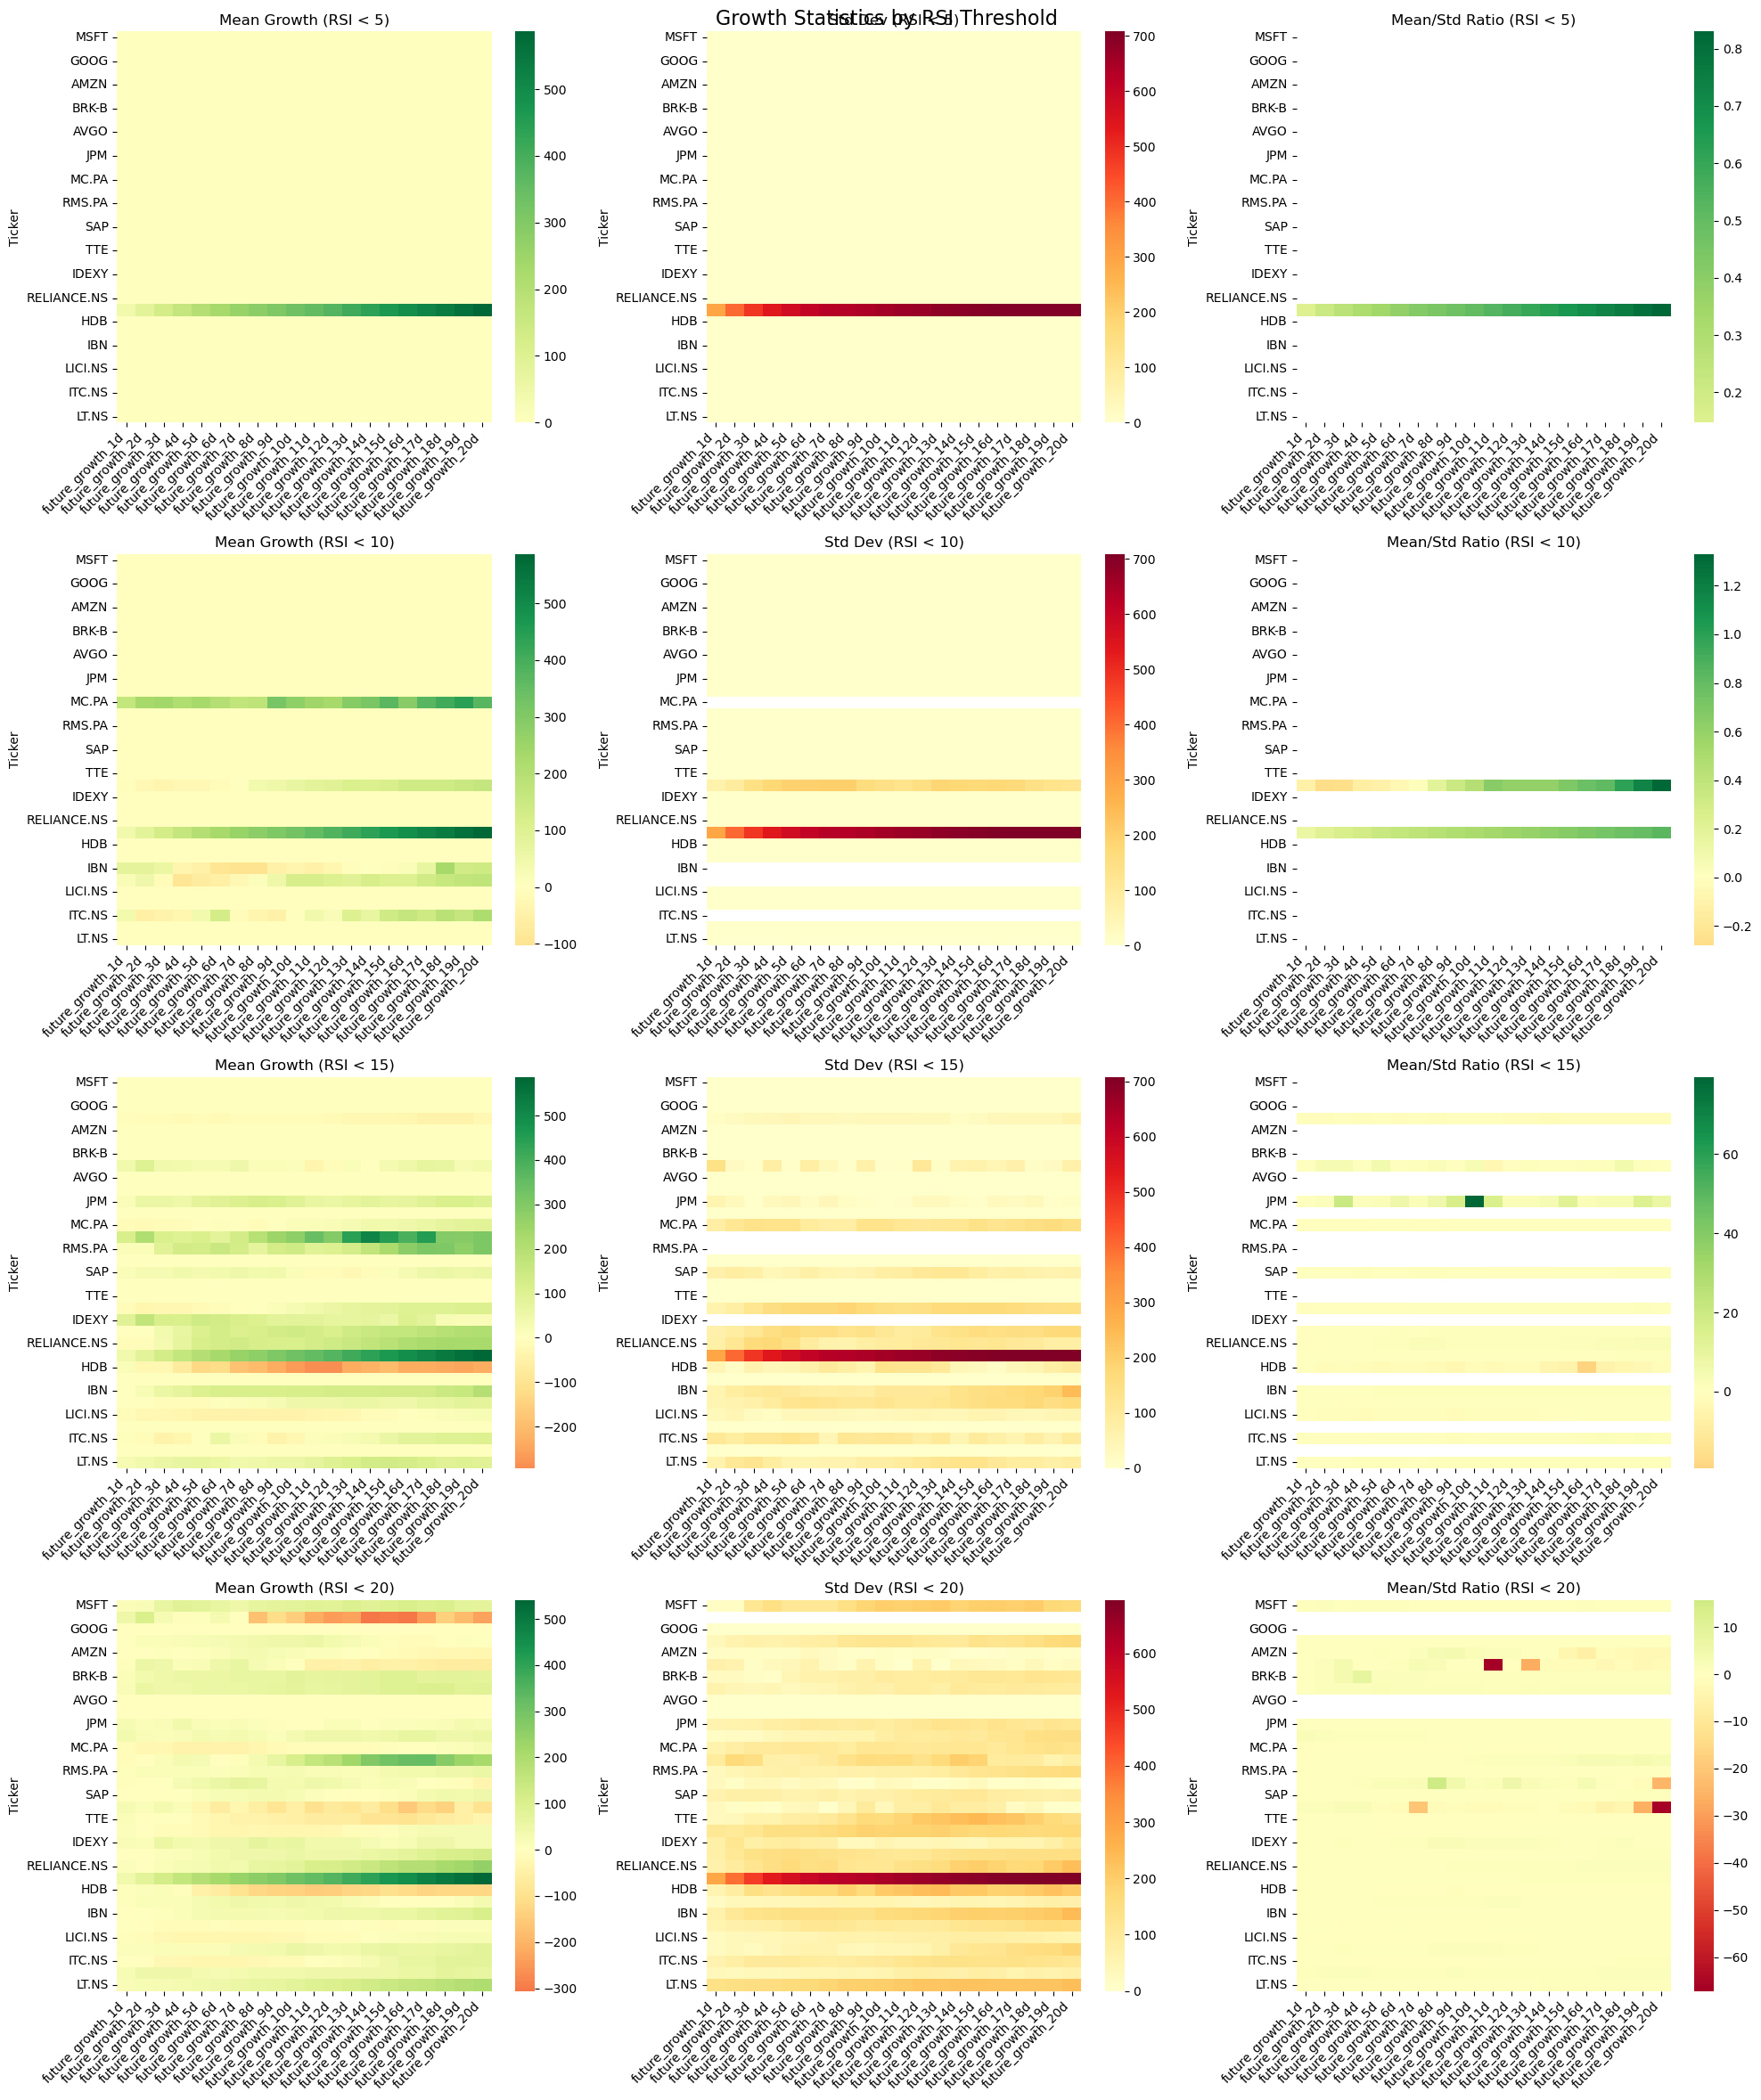

In [95]:
import seaborn as sns
rsi_thresholds = range(5, 25, 5)
# future_days = range(1,21, 1)

# for future_day in future_days:
#     df[f'future_growthd_{future_day}d'] = df['Close_x'].shift(-future_day) / df['Close_x']
# growth_columns = [col for col in df.columns if col.startswith('future_growthd_')] 
    
future_days = range(21, 12*21, 21)
future_days = range(1,21, 1)

for future_day in future_days:
    df[f'future_growth_{future_day}d'] = df['Close_x'].shift(-future_day) / df['Close_x']

growth_columns = [f'future_growth_{future_day}d' for future_day in future_days]


net_incomes_less_threshold_per_ticker_mean = np.full((len(rsi_thresholds), len(growth_columns)), np.nan)
net_incomes_less_threshold_per_ticker_std = np.full((len(rsi_thresholds), len(growth_columns)), np.nan)
all_tickers = df['Ticker'].unique()

# Create empty list to store dataframes for each threshold
mean_dfs_to_concat = []
std_dfs_to_concat = []

for rsi_threshold in rsi_thresholds:
    selected_df_less_than_threshold = df[
        (df['rsi'] < rsi_threshold) &
        (df['Date'] >= '2000-01-01') &
        (df['Date'] <= '2025-06-01')
    ]
    
    # Calculate mean of growth columns per ticker and convert to percentage change
    mean_growth = 1000 * (selected_df_less_than_threshold.groupby('Ticker')[growth_columns].mean()- 1)
    mean_growth = mean_growth.reindex(all_tickers, fill_value=0)
    mean_growth['rsi_threshold'] = rsi_threshold
   
    std_growth = 1000 * selected_df_less_than_threshold.groupby('Ticker')[growth_columns].std()
    std_growth = std_growth.reindex(all_tickers, fill_value=0)
    std_growth['rsi_threshold'] = rsi_threshold
    
    mean_dfs_to_concat.append(mean_growth)
    std_dfs_to_concat.append(std_growth)

# Concatenate all dataframes
net_incomes_less_threshold_per_ticker_mean = pd.concat(mean_dfs_to_concat)
net_incomes_less_threshold_per_ticker_std = pd.concat(std_dfs_to_concat)

    
    
    

print(list(selected_df_less_than_threshold['Ticker'].unique()))
# Count occurrences where RSI is below each threshold for each ticker
rsi_counts_df = pd.DataFrame(rsi_counts, index=rsi_thresholds, columns=list(all_tickers))
print(rsi_counts_df)
# net_incomes_less_than_threshold_mean = net_incomes_less_than_threshold_mean / np.array(future_days)[None,:]
# net_incomes_less_than_threshold_std = net_incomes_less_than_threshold_std / np.array(future_days)[None,:]

# Create figure with subplots for each RSI threshold
fig, axes = plt.subplots(len(rsi_thresholds), 3, figsize=(20, 6*len(rsi_thresholds)))
fig.suptitle('Growth Statistics by RSI Threshold', fontsize=16)

# For each RSI threshold
for i, rsi_threshold in enumerate(rsi_thresholds):
    # Get data for this threshold
    mean_data = net_incomes_less_threshold_per_ticker_mean[
        net_incomes_less_threshold_per_ticker_mean['rsi_threshold'] == rsi_threshold
    ].drop('rsi_threshold', axis=1)
    
    std_data = net_incomes_less_threshold_per_ticker_std[
        net_incomes_less_threshold_per_ticker_std['rsi_threshold'] == rsi_threshold
    ].drop('rsi_threshold', axis=1)
    
    # Calculate ratio
    ratio_data = mean_data / std_data
    
    # Create heatmaps
    sns.heatmap(mean_data, ax=axes[i,0], cmap='RdYlGn', center=0)
    sns.heatmap(std_data, ax=axes[i,1], cmap='YlOrRd')
    sns.heatmap(ratio_data, ax=axes[i,2], cmap='RdYlGn', center=0)
    
    # Set titles
    axes[i,0].set_title(f'Mean Growth (RSI < {rsi_threshold})')
    axes[i,1].set_title(f'Std Dev (RSI < {rsi_threshold})')
    axes[i,2].set_title(f'Mean/Std Ratio (RSI < {rsi_threshold})')
    
    # Rotate x-axis labels
    for ax in axes[i]:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()



/var/folders/53/hnkr1cdj0l52pdybl21x__fr0000gn/T/ipykernel_50750/4190546265.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['rsi'] = talib.RSI(selected_df['Close_x'], timeperiod=14)


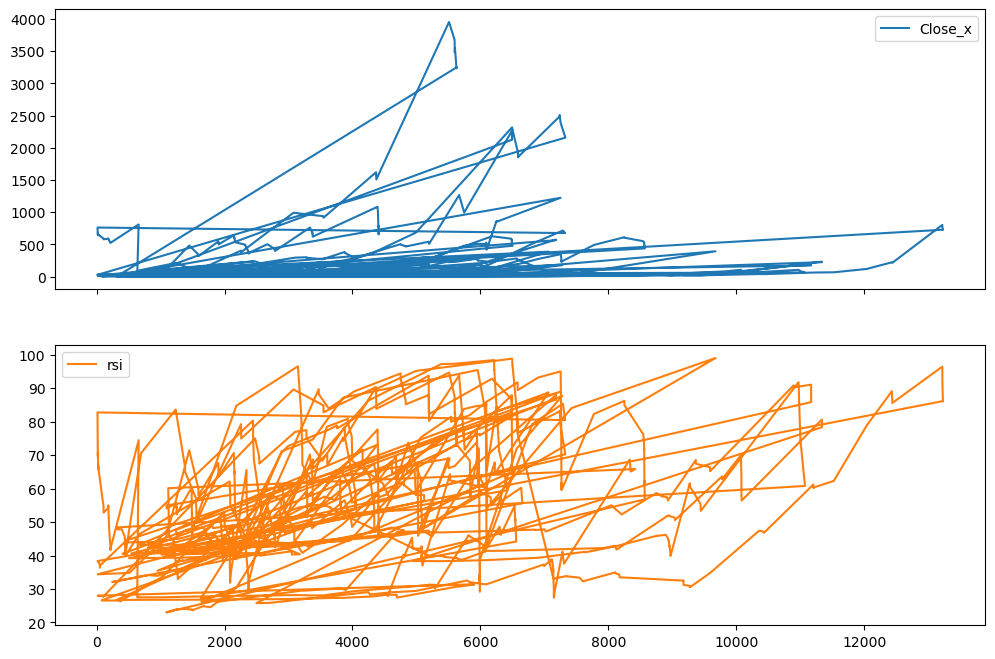

In [32]:
import talib
talib.__version__
selected_df['rsi'] = talib.RSI(selected_df['Close_x'], timeperiod=14)

selected_df[['Close_x', 'rsi']].plot(subplots=True, figsize=(12, 8))
plt.show()
